In this project, we will analyze a dataset of the top 100 ranked hiking trails in the state of Georgia according to alltrails.com. We will then build a model from publicly available features to predict trail difficulty, as determined by the community. Let's start by opening the dataset and looking at what we have.

In [1]:
import pandas as pd

filename='../Data/Georgia hiking trails.csv'
df=pd.read_csv(filename)
print(df.shape)
df.head()

(100, 15)


,Rank,Name,Length,Elevation gain,Rocky,Scramble,No shade,Slippery,Stairs,Muddy,Roots,Easy,Moderate,Hard,Strenuous
0,1,Mount Yonah Trail,4.3,1489,1,1,0,0,0,0,0,11,219,285,38
1,2,East Palisades Trail and Bamboo Forest,4.2,495,0,0,0,1,0,0,1,55,202,10,0
2,3,Cloudland Canyon West Rim Loop,4.7,705,1,0,0,0,1,0,0,44,273,27,1
3,4,Tallulah Gorge and North and South Rim Loop Trail,1.8,534,1,0,0,0,1,0,0,47,169,41,18
4,5,Indian Seats Loop,3.5,508,1,0,0,0,0,0,0,87,198,2,0


As you can see, we have a dataframe containing 100 rows, which correspond to the top 100 trails. Additionally, we have the rank of the trail, its name, its length in miles, and its elevation gain in feet. These values were obtained directly from alltrails.com. The next seven columns (Rocky, Scramble, No shade, Slippery, Stairs, Muddy, and Roots) attempt to quantify features that contribute to hike difficulty but are unrelated to length, elevation gain, grade, etc. These features were also obtained from AllTrails, although it was a more indirect process. I used three sources to compile these values. The first was the list of obstacles in the "Plan your visit" section in the trail page: 

<img src="../Images/obstacles1.png" width="400" height="200" style="display: block; margin: auto; max-width: 100%;" /> 

I noticed that obstacles were easy to identify in this section for the top-rated hikes, but most of the hikes further down the list did not include this section at all. The second source I used to identify obstacles was the AI-generated "Trailgoers are saying" section: 

<img src="../Images/obstacles2.png" width="400" height="200" style="display: block; margin: auto; max-width: 100%;" />

Finally, I used the summary listed directly beneath the trail metrics:

<img src="../Images/obstacles3.png" width="400" height="200" style="display: block; margin: auto; max-width: 100%;" />

It should be noted that there was some amount of arbitrariness in collecting these features since I was relying entirely on the community's reporting of trail obstacles. Also, there were a few cases where I had to make a "judgement call" about whether to quantify a description as belonging to a particular obstacle type. Finally, I did not include obstacle types that I decided would have no effect on trail difficulty, such as difficult parking situations and crowding conditions.

The final four columns contain the counts of the four difficulty ratings: easy, moderate, hard, and strenuous. We will use these counts to produce the targets for our prediction task. AllTrails itself also provides a difficulty rating for every trail, but I determined two distinct advantages in using the community ratings instead. Firstly, the community ratings provide a better representation of how hikers feel about trails. Secondly, using the community ratings allows us to transform our problem into a regression task, avoiding the problem of imbalanced classification (which is notable in this case since AllTrails rates most of the hikes on the list as moderate).

Next, let's get a sense of the distribution of our features, starting with trail length and elevation gain.

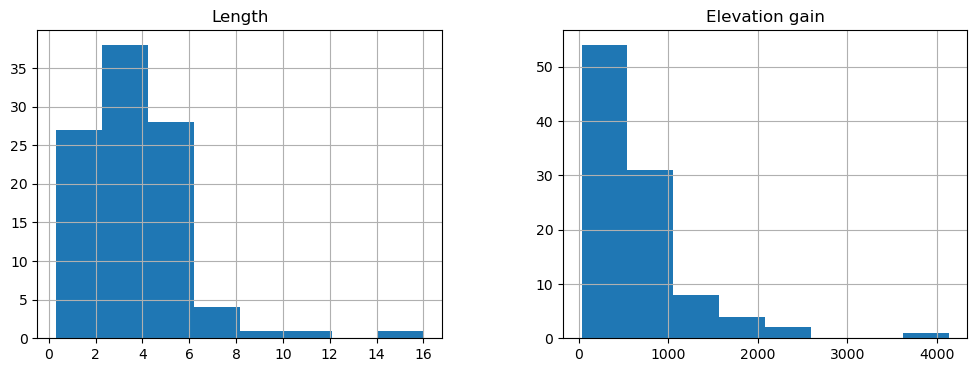

In [2]:
import matplotlib.pyplot as plt

df[['Length','Elevation gain']].hist(bins=8,figsize=(12,4))
plt.show()

For length, the vast majority of the hikes fall between 0 and 6 miles, and a strong majority of hikes have an elevation gain under 1000 feet. We can see that both histograms contain a single outlier: between 14 and 16 miles in length and around 4000 feet in elevation gain. This outlier corresponds to the Appalachian Approach Trail to Springer Mountain trail, which has a length of 16 miles and an elevation gain of 4137 feet.

Let's also look at the distribution of our obstacle features.

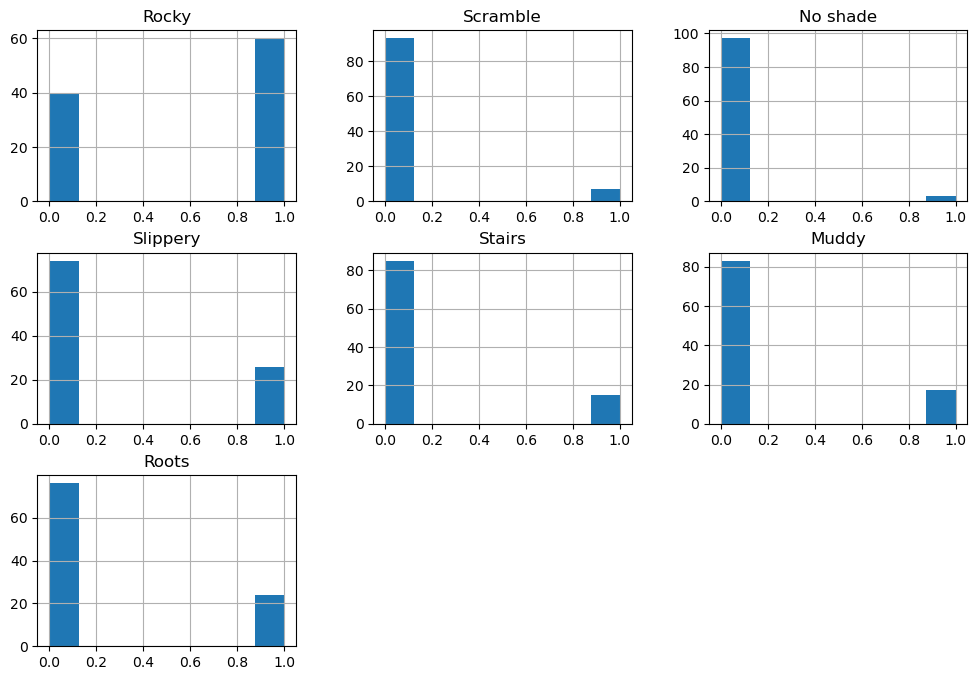

In [3]:
df[['Rocky','Scramble','No shade','Slippery','Stairs',
   'Muddy','Roots']].hist(bins=8,figsize=(12,8))
plt.show()

Generally, the 0 (not present) case strongly outnumbers the 1 (present) case. This is particularly true for the Scramble and No shade features, which barely have any representation at all. As such, they will most likely not be useful features for our model.

Now we should consider whether it's possible to generate any additional useful features from our starting features. A feature that immediately comes to mind is the average grade, which is simply the elevation gain divided by the length. Let's compute this feature and view its distribution.

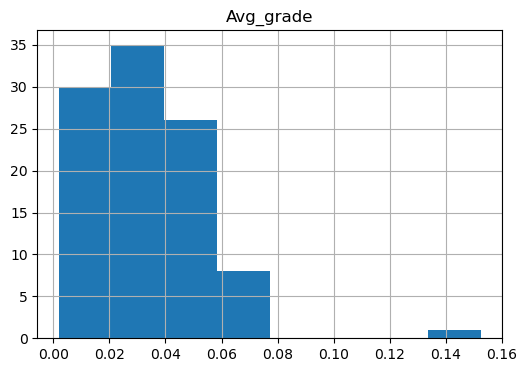

In [4]:
df['Avg_grade']=df['Elevation gain']/(df['Length']*5280)
df['Avg_grade'].hist(bins=8,figsize=(6,4))
plt.title('Avg_grade')
plt.show()

The vast majority of values fall between 0 and 0.06. The outlier value at 0.15 corresponds to the Amicalola Falls trail, which consists of numerous staircases leading from the bottom of the falls to the top.

As mentioned previously, we will be generating regression targets for this task. To do this, I assigned easy ratings a difficulty value of 1, moderate ratings a value of 4, hard ratings a value of 7, and strenuous ratings a value of 10. I then computed a weighted average to obtain a final difficulty rating for each trail. In this way, we have a system that rates trail difficulty on an intuitive 1 to 10 scale. Having done this, let's plot the histogram of the weighted average difficulty ratings.

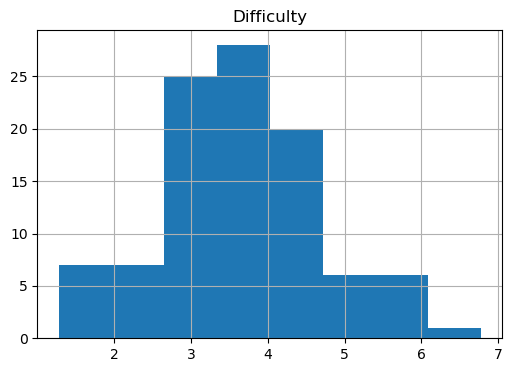

In [5]:
df['Difficulty']=(df['Easy']+4*df['Moderate']+7*df['Hard']+10*df['Strenuous'])/(df['Easy']+df['Moderate']+df['Hard']+df['Strenuous'])
df['Difficulty'].hist(bins=8,figsize=(6,4))
plt.title('Difficulty')
plt.show()

Most of the ratings fall between 3 and 5, which makes sense considering that AllTrails considers most of the hikes on the list to be moderate (note: a 100% moderate-rated trail corresponds to a value of 4 in our difficulty system). The lowest rating is 1.28 (Unicoi Lake Loop) and the highest rating is 6.78 (Appalachian Approach Trail to Springer Mountain).

Now let's compute Pearson correlations between our input features and targets.

In [6]:
correlation_table = df.drop(['Rank','Name','Easy','Moderate','Hard','Strenuous'],axis=1).corr().round(2)
print(correlation_table)

                Length  Elevation gain  Rocky  Scramble  No shade  Slippery  \
Length            1.00            0.79   0.21      0.01     -0.02     -0.04   
Elevation gain    0.79            1.00   0.23      0.11     -0.06     -0.09   
Rocky             0.21            0.23   1.00      0.22      0.14      0.16   
Scramble          0.01            0.11   0.22      1.00     -0.05     -0.07   
No shade         -0.02           -0.06   0.14     -0.05      1.00      0.16   
Slippery         -0.04           -0.09   0.16     -0.07      0.16      1.00   
Stairs           -0.07            0.12   0.06      0.10     -0.07     -0.06   
Muddy            -0.07           -0.15  -0.12     -0.02     -0.08     -0.15   
Roots            -0.20           -0.20   0.17     -0.06     -0.10      0.20   
Avg_grade        -0.12            0.37   0.03      0.14     -0.04      0.02   
Difficulty        0.45            0.73   0.26      0.29     -0.04      0.06   

                Stairs  Muddy  Roots  Avg_grade  Di

Length and elevation gain are highly positively correlated, which makes sense since there is more opportunity to ascend and descend as a trail increases in length. As for the targets (Difficulty), it is strongly positively correlated with length (0.45), elevation gain (0.73), and average grade (0.64), while it is somewhat positively correlated with rocky conditions (0.26), scrambling requirements (0.29), and stairs (0.30). Curiously, it is weakly negatively negatively correlated with muddy conditions (-0.22) and the presence of tree roots (-0.21). It's possible that this is occurring because more difficult trails neglect to mention these conditions since they pale in comparison to the difficulty of more strenuous challenges (steepness, length, etc.), and thus the trails that do mention them tend to be easier. Finally, the difficulty rating seems to have no correlation with no shade conditions (-0.04) and slippery conditions (0.06).

To create our new dataset, let's drop features that are either poorly represented in the dataset or have no correlation with the targets, as well as the difficulty rating counts that we no longer need since we generated overall difficulty ratings.

In [7]:
df.drop(['Scramble','No shade','Slippery','Easy','Moderate','Hard','Strenuous'],axis=1).to_csv('../Data/hiking1.csv',index=False)